# Filament initialization in a sphere

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
rng = np.random.default_rng() # initialize generator instance
from mpl_toolkits import mplot3d # for vizualization
%matplotlib notebook

This is a filament initializer that places the center points of filaments inside a sphere. If a constant director is chosen, this can lead to a tactoid-like configuration of filaments.

Author: Saad J. Ansari (2020)

In [23]:
# Define some constants
R = 0.225 # radius of sphere (micron)
vol_sphere = (4/3) * math.pi * R**3
n_fil = 1600;
use_pack_frac = False
pack_frac = 0.3 # packing fraction (volume of filaments inside sphere/total volume of sphere)

D = 0.007 # diameter of filaments (micron)
director = np.array([0, 0, 1]) # director vector (CAN BE RANDOMIZED)
Lmin = 0.09 # minimum length of filaments
Lmax = 0.28 # maximum length of filaments
Lmean = 0.18 # mean length of filaments
use_exp_filament_length = True # flag to sample from an exponential distribution of lengths (cutoff with Lmin and Lmax)

fname = './TubuleInitial_n1600_poly.dat'
write_file = True
run_visualization = True
run_tests = False
system_offset = [1,1,1]

### Description:

We do this in the following way:
* Randomly sample $(x,y,z)$ where $x,y,z \in [-R,R]$ such that $x^2 + y^2 + z^2 < R^2$
* Attempt to add a filament at the sampled position:
    * Check for minimum distance to all pre-existing filaments.
    * If minimum distance is less than the filament diameter $D$, a filament instance is created and **successfully added** to a filament list.
    * If minimum distance condition is not met, the filament is **not added** to the list.
    * If a filament is added successfully, we continue. Otherwise, we sample another point and attempt a filament addition before proceeding.
* Once a filament is added, we calculate the a packing fraction for the system (if enabled).
* The steps above are repeated. The program stops when:
    * The specified number of filaments are attained, or an addition attempt fails 5000 consecutive times.
    * The specified packing fraction is attained (if enabled)

We begin by creating the machinery to achieve this.

1. **Filament( )** (class): Useful way to store information (start pt, end pt, gid, length, director) about a given filament. The choice of a class is natural when multiple instances need to be created.


2. **minDistBetweenTwoFil( )**: Calculates the minimum distance between two filaments. It parametrizes the filaments with $(s,t)$ and seeks a global minimum of $W(s,t)$, the squared distance between any two points on the two lines. If the global minimum lies outside the range of $s$ and $t$ ($s \in [0,1]$, $t \in [0,1]$), then it checks all the edges for a minimum distance. It works for both parallel and non-parallel, overlapping and skew filaments. This is adapted from http://softsurfer.com/Archive/algorithm_0106/algorithm_0106.htm#dist3D_Segment_to_Segment.


3. **minDistFilAll( )**: Calcutes the minimum distance between a single filament and a list of filaments. It loops over all filaments in the list and uses *minDistBetweenTwoFil()* to evaluate pair-pair distances. 


4. **getLengthRandomExp( )**: samples a value from an exponential distribution with min and max cutoffs for the values. We use this to sample filament lengths if enabled.


5. **sph2cart**/**cart2sph**:  transformations between cartesian and spherical coordinates.


6. **getFilamentLengthInsideSphere( )**: finds the length of a filament that lies inside a spherical region. It does that by getting points along a filament and checking their radial coordinate (in the spherical coordinate system). This gives an enclosed length of a filament which can be used to calculate an enclosed volume.

7. **getRand3PointInSphere( )**: get a random point in 3D space that is inside the sphere of some specified radius.

### Notes:

* The packing fraction calculation uses the value inside the initialization sphere. We assume that this is an accurate representation of the packing fraction throughout the system.
* The code can be easily modified to get an isotropic initial condition (randomly sample the director vector)

### Code:

In [24]:
# Define a filament class
class Filament():
    def __init__(self, center, director, leng, radius):
        self.center = center
        self.director = director/ np.linalg.norm(director)
        self.length = leng
        self.radius = radius
        self.pos_start = center - leng/2 * self.director
        self.pos_end = center + leng/2 * self.director
        self.gid = gid # defined outisde the class
    def Plot3(self,ax):
        ax.plot3D( [self.pos_start[0], self.pos_end[0]], [self.pos_start[1], self.pos_end[1]], [self.pos_start[2], self.pos_end[2]], 'red')
    def GetStringtoWrite(self):
        return 'C {0} {1} {2:0.6f} {3:0.6f} {4:0.6f} {5:0.6f} {6:0.6f} {7:0.6f}\n'.format(
        self.gid, self.radius,
        self.pos_start[0], self.pos_start[1], self.pos_start[2],
        self.pos_end[0], self.pos_end[1], self.pos_end[2])
    def __repr__(self):
        return "Filament()"
    def __str__(self):
        return 'Filament {0}:\n  pos_start: {1}\n  pos_end: {2}\n  length: {3}\n  radius: {4}'.format(self.gid, self.pos_start, self.pos_end, self.length,self.radius)

In [25]:
# Find Minimum Distance between two filaments
def minDistBetweenTwoFil(f1, f2):
    # Adapted from matlab
    # https://www.mathworks.com/matlabcentral/fileexchange/32487-shortest-distance-between-two-line-segments
    # which adapted this from Dan Sunday's Geometry Algorithms originally written in C++
    # http://softsurfer.com/Archive/algorithm_0106/algorithm_0106.htm#dist3D_Segment_to_Segment
    
    # p1 = f1.pos_start
    # p2 = f1.pos_end
    # p3 = f2.pos_start
    # p4 = f2.pos_end
    # Computes the minimum distance between two line segments. Code
    # is adapted for Matlab from Dan Sunday's Geometry Algorithms originally
    # written in C++
    # http://softsurfer.com/Archive/algorithm_0106/algorithm_0106.htm#dist3D_Segment_to_Segment
    # Usage: Input the start and end x,y,z coordinates for two line segments. 
    # p1, p2 are [x,y,z] coordinates of first line segment and p3,p4 are for
    # second line segment. 
    # Output: scalar minimum distance between the two segments.
    #  Example:
    #	P1 = [0 0 0];     P2 = [1 0 0];
    #   P3 = [0 1 0];     P4 = [1 1 0];
    #	dist = minDistBetweenTwoFil(P1, P2, P3, P4)
    p1 = f1.pos_start
    p2 = f1.pos_end
    p3 = f2.pos_start
    p4 = f2.pos_end
    
    u = p1 - p2
    v = p3 - p4
    w = p2 - p4
    
    a = np.dot(u,u)
    b = np.dot(u,v)
    c = np.dot(v,v)
    d = np.dot(u,w)
    e = np.dot(v,w)
    D = a*c - b*b
    sD = D
    tD = D
    
    SMALL_NUM = 0.00000001
    
    # compute the line parameters of the two closest points
    if D < SMALL_NUM: # the lines are almost parallel
        sN = 0.0     # force using point P0 on segment S1
        sD = 1.0     # to prevent possible division by 0.0 later
        tN = e
        tD = c
    else:             # get the closest points on the infinite lines
        sN = (b*e - c*d)
        tN = (a*e - b*d)
        if sN < 0.0:   # sc < 0 => the s=0 edge is visible       
            sN = 0.0
            tN = e
            tD = c
        elif sN > sD:  # sc > 1 => the s=1 edge is visible
            sN = sD
            tN = e + b
            tD = c
    
    if tN < 0.0:            # tc < 0 => the t=0 edge is visible
        tN = 0.0
        # recompute sc for this edge
        if -d < 0.0:
            sN = 0.0
        elif -d > a:
            sN = sD
        else:
            sN = -d
            sD = a
    elif tN > tD:       # tc > 1 => the t=1 edge is visible
        tN = tD
        # recompute sc for this edge
        if -d + b < 0.0:
            sN = 0
        elif -d + b > a:
            sN = sD
        else: 
            sN = -d + b
            sD = a
    
    # finally do the division to get sc and tc
    if  np.absolute(sN) < SMALL_NUM:
        sc = 0.0
    else:
        sc = sN / sD
    
    if np.absolute(tN) < SMALL_NUM:
        tc = 0.0
    else:
        tc = tN / tD
    
    # get the difference of the two closest points
    dP = w + (sc * u) - (tc * v);  # = S1(sc) - S2(tc)
    distance = np.linalg.norm(dP);
    outV = dP;
    
    # outV = outV      # vector connecting the closest points
    # cp_1 = p2+sc*u  # Closest point on object 1 
    # cp_2 = p4+tc*v  # Closest point on object 2
    
    return distance

In [26]:
# Define a Minimum Distance from one filament to all other filaments
def minDistFilAll( f1, f_list):
    dists = [ minDistBetweenTwoFil(f1,f2) for f2 in f_list]
    if not dists:
        return 1e6
    else:
        return np.min(dists)

In [27]:
# Define a random length sampler
def getLengthRandomExp( rng, Lmean, Lmin=0, Lmax=1e6):
    val = -1
    while val < Lmin or val > Lmax:
        val = rng.exponential( Lmean)
    return val

In [28]:
# polar to cartesian coordinates
def sph2cart(r, phi, theta):
    return np.array([
         r * math.sin(theta) * math.cos(phi),
         r * math.sin(theta) * math.sin(phi),
         r * math.cos(theta)
    ])
# cartesian to polar coordinates
def cart2sph(x, y, z):
    XsqPlusYsq = x**2 + y**2
    r = math.sqrt(XsqPlusYsq + z**2)               # r
    elev = math.atan2(z,math.sqrt(XsqPlusYsq))     # theta
    az = math.atan2(y,x)                           # phi
    return np.array([r, az, elev])

In [29]:
# volume of filament inside sphere
def getFilamentLengthInsideSphere(f1, rad):
    
    # Find coordinates along the filament whose r coord in (r,phi, theta) lies inside the sphere.
    # Segment the filament into 100 points
    lens = np.linspace(0, f1.length, 100)
    num_in = 0
    for el in lens:
        [x,y,z] = f1.pos_start + el*f1.director
        pt = cart2sph(x,y,z)
        if pt[0] < rad:
            num_in += 1
        
    return (num_in/100)*f1.length

In [30]:
# Get random 3d cartesian point() inside sphere
def getRand3PointInSphere(rad):
    d = 2*rad
    while d > rad:
        xyz = rng.uniform(-rad, rad, 3)
        d = np.linalg.norm(xyz)
    return [xyz[0],xyz[1],xyz[2]]

#    radius = np.random.uniform(0.0,1.0)*rad 
#    theta = np.random.uniform(-1.0,1.0)*math.pi
#    phi = np.arccos(1-2*np.random.uniform(0.0,1.))
#    x = radius * np.sin( theta ) * np.cos( phi )
#    y = radius * np.sin( theta ) * np.sin( phi )
#    z = radius * np.cos( theta )
#    return [x,y,z]

We start with a sphere with radius R. We randomly pick values (r,phi, theta) that define the position of a point in 3D space. We attempt to insert a filament with that point as its center. If the minimum distance between this filament and any other filaments is greater than diameter D of the filaments (i.e filaments do not overlap), we successfully complete the insertion. If insertion fails, we try a new point.

In [34]:
def attemptAddFilament(center, L, director, D, f_list, gid):
    # Initialize a  filament of length L
    fil = Filament(center, director, L, D/2)
    
    # find minimum distance to other filaments, and accept if distance is more than filament diameter
    min_dist = minDistFilAll(fil, f_list)
    status = False
    if min_dist > D:
        f_list.append(fil)
        gid+=1
        print(fil)
        status = True
    return f_list,gid,status

# There are two ways to go about this.
# 1. Attempt to achieve a specified packing fraction
# 2. Attempt to initialize a specified number of rods

gid = 0
f_list = [] # list to store filaments
if use_pack_frac:
    
    v_enclosed = 0 # volume occupied by filaments inside the sphere
    cpf = 0 # current packing fraction tracker
    while cpf < pack_frac:
        center = getRand3PointInSphere(R) # Sample a random (x,y,z inside a sphere)
        
        if use_exp_filament_length:
            L = getLengthRandomExp( rng, Lmean, Lmin, Lmax)
        else:
            L = Lmean
            
        f_list,gid,status = attemptAddFilament(center,L,director, D, f_list, gid)
        if status:
            len_inside = getFilamentLengthInsideSphere( f_list[-1], R) # length of filament inside the sphere
            v_enclosed += math.pi * (D/2)**2 * len_inside # volume of filament inside the sphere
            cpf = v_enclosed / vol_sphere # current packing fraction
            print('CPF = {}'.format(cpf))

    
else:
    
    # sample n_fil length values and sort them
    if use_exp_filament_length:
        lens = sorted( [getLengthRandomExp( rng, Lmean, Lmin, Lmax) for i in range(n_fil)], reverse=True)
    else:
        lens = [Lmean for i in range(n_fil)]
        
    for idx,el in enumerate(lens):
        status = False
        failCount=0
        while not status:
            failCount+=1
            center = getRand3PointInSphere(R) # Sample a random (x,y,z inside a sphere)
            f_list,gid,status = attemptAddFilament(center, el, director, D, f_list, gid)
            if failCount > 5000:
                raise Exception('Failed to add a filament with 5000 trials.\nStopping...\n...\n...\n Total Added Filaments = {}'.format(len(f_list)))

Filament 0:
  pos_start: [ 0.07179151 -0.10528666 -0.07142744]
  pos_end: [ 0.07179151 -0.10528666  0.20850773]
  length: 0.2799351781205802
  radius: 0.0035
Filament 1:
  pos_start: [ 0.03525672 -0.03177667 -0.12621428]
  pos_end: [ 0.03525672 -0.03177667  0.15352799]
  length: 0.2797422715681692
  radius: 0.0035
Filament 2:
  pos_start: [ 0.08293185  0.04424037 -0.20192478]
  pos_end: [0.08293185 0.04424037 0.0771283 ]
  length: 0.2790530778042424
  radius: 0.0035
Filament 3:
  pos_start: [-0.19901634 -0.04707651 -0.1176853 ]
  pos_end: [-0.19901634 -0.04707651  0.16101782]
  length: 0.27870311774466305
  radius: 0.0035
Filament 4:
  pos_start: [ 0.16377042 -0.04620523 -0.05776023]
  pos_end: [ 0.16377042 -0.04620523  0.22090863]
  length: 0.27866885559858234
  radius: 0.0035
Filament 5:
  pos_start: [ 0.07742903  0.0725646  -0.3154486 ]
  pos_end: [ 0.07742903  0.0725646  -0.03710741]
  length: 0.27834118676422875
  radius: 0.0035
Filament 6:
  pos_start: [ 0.02508988 -0.15421381 -0

  radius: 0.0035
Filament 82:
  pos_start: [ 0.02777414 -0.01306473  0.00161587]
  pos_end: [ 0.02777414 -0.01306473  0.26551012]
  length: 0.2638942435053169
  radius: 0.0035
Filament 83:
  pos_start: [ 0.03005494  0.04590612 -0.33590527]
  pos_end: [ 0.03005494  0.04590612 -0.07222856]
  length: 0.2636767135897806
  radius: 0.0035
Filament 84:
  pos_start: [-0.00103827  0.0059395  -0.22431808]
  pos_end: [-0.00103827  0.0059395   0.03922841]
  length: 0.2635464862589093
  radius: 0.0035
Filament 85:
  pos_start: [0.04876608 0.04570911 0.07274499]
  pos_end: [0.04876608 0.04570911 0.33604794]
  length: 0.2633029491363869
  radius: 0.0035
Filament 86:
  pos_start: [-0.01744597  0.02312085  0.00179793]
  pos_end: [-0.01744597  0.02312085  0.26509448]
  length: 0.263296547943463
  radius: 0.0035
Filament 87:
  pos_start: [-0.13387806  0.06589998 -0.11055644]
  pos_end: [-0.13387806  0.06589998  0.15272936]
  length: 0.2632857977826252
  radius: 0.0035
Filament 88:
  pos_start: [ 0.061426

Filament 153:
  pos_start: [-0.09627971 -0.06869467  0.01875365]
  pos_end: [-0.09627971 -0.06869467  0.27071066]
  length: 0.2519570076107897
  radius: 0.0035
Filament 154:
  pos_start: [-0.02072411 -0.07908499 -0.29922568]
  pos_end: [-0.02072411 -0.07908499 -0.04792843]
  length: 0.2512972474660262
  radius: 0.0035
Filament 155:
  pos_start: [-0.08977997 -0.17384671 -0.11300234]
  pos_end: [-0.08977997 -0.17384671  0.13785902]
  length: 0.2508613550799887
  radius: 0.0035
Filament 156:
  pos_start: [-0.14162604  0.09103765 -0.11992563]
  pos_end: [-0.14162604  0.09103765  0.13092982]
  length: 0.2508554575946908
  radius: 0.0035
Filament 157:
  pos_start: [ 0.14145449 -0.06332956 -0.28625756]
  pos_end: [ 0.14145449 -0.06332956 -0.03554125]
  length: 0.25071631138550615
  radius: 0.0035
Filament 158:
  pos_start: [ 0.07562769  0.16524841 -0.20048615]
  pos_end: [0.07562769 0.16524841 0.05022054]
  length: 0.2507066888233305
  radius: 0.0035
Filament 159:
  pos_start: [ 0.00235443 -0

Filament 206:
  pos_start: [ 0.01496255  0.05059274 -0.17603308]
  pos_end: [0.01496255 0.05059274 0.06766717]
  length: 0.24370024615813177
  radius: 0.0035
Filament 207:
  pos_start: [-0.13076627  0.09168395 -0.08461423]
  pos_end: [-0.13076627  0.09168395  0.15902296]
  length: 0.2436371944106774
  radius: 0.0035
Filament 208:
  pos_start: [ 0.02667412 -0.18128175 -0.24573524]
  pos_end: [ 0.02667412 -0.18128175 -0.00227238]
  length: 0.24346285346353055
  radius: 0.0035
Filament 209:
  pos_start: [-0.06176336 -0.13675243 -0.06393214]
  pos_end: [-0.06176336 -0.13675243  0.17932658]
  length: 0.24325871904919244
  radius: 0.0035
Filament 210:
  pos_start: [-0.10121117  0.04158007 -0.0420938 ]
  pos_end: [-0.10121117  0.04158007  0.20113442]
  length: 0.24322822496559313
  radius: 0.0035
Filament 211:
  pos_start: [ 0.12654062 -0.1068552   0.02717803]
  pos_end: [ 0.12654062 -0.1068552   0.26995412]
  length: 0.24277609163070088
  radius: 0.0035
Filament 212:
  pos_start: [ 0.0985849

  radius: 0.0035
Filament 270:
  pos_start: [-0.06743258 -0.06450265 -0.04417059]
  pos_end: [-0.06743258 -0.06450265  0.18675561]
  length: 0.23092620132830516
  radius: 0.0035
Filament 271:
  pos_start: [-0.11826682  0.15159728 -0.06041027]
  pos_end: [-0.11826682  0.15159728  0.17039779]
  length: 0.23080806087219333
  radius: 0.0035
Filament 272:
  pos_start: [-0.13293538  0.13689796 -0.0983339 ]
  pos_end: [-0.13293538  0.13689796  0.13202969]
  length: 0.2303635887126406
  radius: 0.0035
Filament 273:
  pos_start: [ 0.1387453   0.15851583 -0.14624392]
  pos_end: [0.1387453  0.15851583 0.08409155]
  length: 0.23033547301919075
  radius: 0.0035
Filament 274:
  pos_start: [-0.09709908 -0.02862275 -0.30390332]
  pos_end: [-0.09709908 -0.02862275 -0.0738519 ]
  length: 0.23005142066826934
  radius: 0.0035
Filament 275:
  pos_start: [-0.00020777 -0.11566845 -0.18317516]
  pos_end: [-0.00020777 -0.11566845  0.04686141]
  length: 0.23003657225867538
  radius: 0.0035
Filament 276:
  pos_s

Filament 332:
  pos_start: [ 0.10788758 -0.11994138 -0.15172621]
  pos_end: [ 0.10788758 -0.11994138  0.06921034]
  length: 0.22093655351945418
  radius: 0.0035
Filament 333:
  pos_start: [-0.04712799  0.08124136  0.01616751]
  pos_end: [-0.04712799  0.08124136  0.23686437]
  length: 0.22069686391732377
  radius: 0.0035
Filament 334:
  pos_start: [ 0.18246191  0.05531889 -0.06716248]
  pos_end: [0.18246191 0.05531889 0.15346581]
  length: 0.22062828347055152
  radius: 0.0035
Filament 335:
  pos_start: [-0.1250088   0.0573166  -0.25594232]
  pos_end: [-0.1250088  0.0573166 -0.0353286]
  length: 0.220613723318529
  radius: 0.0035
Filament 336:
  pos_start: [ 0.11383978 -0.06223051 -0.02268843]
  pos_end: [ 0.11383978 -0.06223051  0.19765043]
  length: 0.2203388658379921
  radius: 0.0035
Filament 337:
  pos_start: [ 0.17970777 -0.08732961 -0.13238072]
  pos_end: [ 0.17970777 -0.08732961  0.08789106]
  length: 0.2202717767536726
  radius: 0.0035
Filament 338:
  pos_start: [0.11860761 0.054

Filament 387:
  pos_start: [ 0.07727472 -0.13552761 -0.2335976 ]
  pos_end: [ 0.07727472 -0.13552761 -0.01964901]
  length: 0.21394858988601329
  radius: 0.0035
Filament 388:
  pos_start: [ 0.050843   -0.20057369 -0.12266387]
  pos_end: [ 0.050843   -0.20057369  0.09109044]
  length: 0.2137543139409275
  radius: 0.0035
Filament 389:
  pos_start: [-0.01006592 -0.17242752 -0.06753467]
  pos_end: [-0.01006592 -0.17242752  0.14618393]
  length: 0.21371860593717862
  radius: 0.0035
Filament 390:
  pos_start: [ 0.12616587 -0.03971289 -0.0450678 ]
  pos_end: [ 0.12616587 -0.03971289  0.16864744]
  length: 0.21371524119562915
  radius: 0.0035
Filament 391:
  pos_start: [ 0.03260612  0.06788584 -0.11679224]
  pos_end: [0.03260612 0.06788584 0.09684215]
  length: 0.21363438732005305
  radius: 0.0035
Filament 392:
  pos_start: [ 0.13657328  0.0574284  -0.23072404]
  pos_end: [ 0.13657328  0.0574284  -0.01716979]
  length: 0.21355424711733004
  radius: 0.0035
Filament 393:
  pos_start: [-0.1503366

  radius: 0.0035
Filament 446:
  pos_start: [-0.08395236 -0.06032702 -0.17900465]
  pos_end: [-0.08395236 -0.06032702  0.02457768]
  length: 0.20358232927883296
  radius: 0.0035
Filament 447:
  pos_start: [ 0.05780307  0.03244688 -0.17749849]
  pos_end: [0.05780307 0.03244688 0.02607721]
  length: 0.20357570134311942
  radius: 0.0035
Filament 448:
  pos_start: [-0.11868519 -0.10308871 -0.16175736]
  pos_end: [-0.11868519 -0.10308871  0.04173864]
  length: 0.20349600368083268
  radius: 0.0035
Filament 449:
  pos_start: [-0.014012    0.20474263 -0.16993063]
  pos_end: [-0.014012    0.20474263  0.03353869]
  length: 0.20346931814937674
  radius: 0.0035
Filament 450:
  pos_start: [ 0.06188008 -0.13999996 -0.00290501]
  pos_end: [ 0.06188008 -0.13999996  0.20049001]
  length: 0.20339501134805568
  radius: 0.0035
Filament 451:
  pos_start: [ 0.15112452 -0.0228855   0.02406934]
  pos_end: [ 0.15112452 -0.0228855   0.22737544]
  length: 0.20330609642634595
  radius: 0.0035
Filament 452:
  pos_

Filament 507:
  pos_start: [-0.14699946  0.04818757 -0.00121108]
  pos_end: [-0.14699946  0.04818757  0.19421284]
  length: 0.1954239221503288
  radius: 0.0035
Filament 508:
  pos_start: [-0.07424597 -0.03585992 -0.21800838]
  pos_end: [-0.07424597 -0.03585992 -0.02264768]
  length: 0.19536070055121102
  radius: 0.0035
Filament 509:
  pos_start: [-0.11743578  0.19041636 -0.0782536 ]
  pos_end: [-0.11743578  0.19041636  0.11704803]
  length: 0.1953016302423982
  radius: 0.0035
Filament 510:
  pos_start: [-0.04169567 -0.05984532 -0.18146813]
  pos_end: [-0.04169567 -0.05984532  0.01372179]
  length: 0.19518992716979372
  radius: 0.0035
Filament 511:
  pos_start: [-0.03127013  0.05473314 -0.23011048]
  pos_end: [-0.03127013  0.05473314 -0.03493985]
  length: 0.19517062429485887
  radius: 0.0035
Filament 512:
  pos_start: [-0.14799329  0.15363939 -0.03924149]
  pos_end: [-0.14799329  0.15363939  0.15579095]
  length: 0.19503244342391482
  radius: 0.0035
Filament 513:
  pos_start: [ 0.03707

Filament 566:
  pos_start: [ 0.01497274 -0.03817435  0.02440503]
  pos_end: [ 0.01497274 -0.03817435  0.2133883 ]
  length: 0.18898327073125754
  radius: 0.0035
Filament 567:
  pos_start: [-0.04880997  0.0084741  -0.16395127]
  pos_end: [-0.04880997  0.0084741   0.0250282 ]
  length: 0.18897947145063315
  radius: 0.0035
Filament 568:
  pos_start: [-0.13063465 -0.03126779  0.02801054]
  pos_end: [-0.13063465 -0.03126779  0.21682272]
  length: 0.18881217908186954
  radius: 0.0035
Filament 569:
  pos_start: [-0.12520449  0.01953413 -0.17816696]
  pos_end: [-0.12520449  0.01953413  0.01061736]
  length: 0.18878431126185516
  radius: 0.0035
Filament 570:
  pos_start: [-0.07497038  0.13546282  0.03969858]
  pos_end: [-0.07497038  0.13546282  0.2284643 ]
  length: 0.18876572864108496
  radius: 0.0035
Filament 571:
  pos_start: [ 0.05173658 -0.02626608  0.0203029 ]
  pos_end: [ 0.05173658 -0.02626608  0.20891224]
  length: 0.1886093418111402
  radius: 0.0035
Filament 572:
  pos_start: [0.10476

Filament 623:
  pos_start: [-0.17747748  0.01355632 -0.20234073]
  pos_end: [-0.17747748  0.01355632 -0.01853393]
  length: 0.1838067968575757
  radius: 0.0035
Filament 624:
  pos_start: [-0.0594491   0.15391208 -0.13829586]
  pos_end: [-0.0594491   0.15391208  0.04547892]
  length: 0.1837747799982097
  radius: 0.0035
Filament 625:
  pos_start: [ 0.09627819 -0.11638161 -0.16027782]
  pos_end: [ 0.09627819 -0.11638161  0.0233894 ]
  length: 0.18366721832700367
  radius: 0.0035
Filament 626:
  pos_start: [-0.04980268  0.20379141 -0.08558585]
  pos_end: [-0.04980268  0.20379141  0.0979715 ]
  length: 0.18355735616289456
  radius: 0.0035
Filament 627:
  pos_start: [-0.03561169 -0.00148319  0.11758071]
  pos_end: [-0.03561169 -0.00148319  0.30113714]
  length: 0.1835564260641527
  radius: 0.0035
Filament 628:
  pos_start: [ 0.11330499  0.14682199 -0.04746409]
  pos_end: [0.11330499 0.14682199 0.13596548]
  length: 0.18342957012079872
  radius: 0.0035
Filament 629:
  pos_start: [-0.04646708 

Filament 678:
  pos_start: [-0.03174552 -0.0718608  -0.23430735]
  pos_end: [-0.03174552 -0.0718608  -0.0564274 ]
  length: 0.17787995184978417
  radius: 0.0035
Filament 679:
  pos_start: [-0.00700178  0.20222586 -0.0509595 ]
  pos_end: [-0.00700178  0.20222586  0.12682134]
  length: 0.17778083910042333
  radius: 0.0035
Filament 680:
  pos_start: [ 0.18486073 -0.01361634 -0.06248957]
  pos_end: [ 0.18486073 -0.01361634  0.1152483 ]
  length: 0.17773787001180208
  radius: 0.0035
Filament 681:
  pos_start: [ 0.11897131  0.09776796 -0.10806741]
  pos_end: [0.11897131 0.09776796 0.06930087]
  length: 0.1773682873730249
  radius: 0.0035
Filament 682:
  pos_start: [ 0.04440204  0.15897727 -0.22340442]
  pos_end: [ 0.04440204  0.15897727 -0.04609303]
  length: 0.1773113908913757
  radius: 0.0035
Filament 683:
  pos_start: [-0.07206376 -0.15510855 -0.11102936]
  pos_end: [-0.07206376 -0.15510855  0.06621866]
  length: 0.17724802522556637
  radius: 0.0035
Filament 684:
  pos_start: [0.02978998 

Filament 733:
  pos_start: [-0.01766205  0.1214553  -0.03128719]
  pos_end: [-0.01766205  0.1214553   0.14021842]
  length: 0.17150561397329347
  radius: 0.0035
Filament 734:
  pos_start: [ 0.18679131 -0.06561613 -0.00304011]
  pos_end: [ 0.18679131 -0.06561613  0.16845671]
  length: 0.17149682554157608
  radius: 0.0035
Filament 735:
  pos_start: [ 0.12515947 -0.08089321 -0.02667593]
  pos_end: [ 0.12515947 -0.08089321  0.14481039]
  length: 0.1714863276276573
  radius: 0.0035
Filament 736:
  pos_start: [-0.13906554 -0.01838697 -0.18325269]
  pos_end: [-0.13906554 -0.01838697 -0.01194848]
  length: 0.1713042044883016
  radius: 0.0035
Filament 737:
  pos_start: [ 0.19683831  0.01435061 -0.13464229]
  pos_end: [0.19683831 0.01435061 0.03657471]
  length: 0.1712169968443607
  radius: 0.0035
Filament 738:
  pos_start: [-0.03033288 -0.15582108 -0.08535901]
  pos_end: [-0.03033288 -0.15582108  0.08583476]
  length: 0.171193764856855
  radius: 0.0035
Filament 739:
  pos_start: [-0.13011739  0

Filament 789:
  pos_start: [ 0.12125007 -0.03350943 -0.13034242]
  pos_end: [ 0.12125007 -0.03350943  0.03539781]
  length: 0.16574022946587158
  radius: 0.0035
Filament 790:
  pos_start: [-0.08379274  0.13544555 -0.08320705]
  pos_end: [-0.08379274  0.13544555  0.08241603]
  length: 0.1656230837329189
  radius: 0.0035
Filament 791:
  pos_start: [-0.11553214  0.07656037 -0.11444961]
  pos_end: [-0.11553214  0.07656037  0.05109089]
  length: 0.16554049483271568
  radius: 0.0035
Filament 792:
  pos_start: [ 0.05916884 -0.16359815 -0.21406948]
  pos_end: [ 0.05916884 -0.16359815 -0.04862396]
  length: 0.16544552726366357
  radius: 0.0035
Filament 793:
  pos_start: [-0.06446491  0.0470999   0.043868  ]
  pos_end: [-0.06446491  0.0470999   0.2092898 ]
  length: 0.16542180373003146
  radius: 0.0035
Filament 794:
  pos_start: [ 0.12127479  0.04007758 -0.1701049 ]
  pos_end: [ 0.12127479  0.04007758 -0.00472985]
  length: 0.16537504809894704
  radius: 0.0035
Filament 795:
  pos_start: [-0.0672

Filament 842:
  pos_start: [ 0.03894011 -0.16993146  0.02737198]
  pos_end: [ 0.03894011 -0.16993146  0.18687724]
  length: 0.15950525891879105
  radius: 0.0035
Filament 843:
  pos_start: [ 0.10270429 -0.15620335 -0.08558755]
  pos_end: [ 0.10270429 -0.15620335  0.07391139]
  length: 0.1594989404620117
  radius: 0.0035
Filament 844:
  pos_start: [0.03268519 0.08773872 0.11165009]
  pos_end: [0.03268519 0.08773872 0.27108704]
  length: 0.15943695399956442
  radius: 0.0035
Filament 845:
  pos_start: [0.11001425 0.02551944 0.10071969]
  pos_end: [0.11001425 0.02551944 0.26009289]
  length: 0.15937320115159984
  radius: 0.0035
Filament 846:
  pos_start: [-0.15652479  0.00336942  0.0154424 ]
  pos_end: [-0.15652479  0.00336942  0.17468617]
  length: 0.15924376880746524
  radius: 0.0035
Filament 847:
  pos_start: [-0.13881974 -0.00049496 -0.18713198]
  pos_end: [-0.13881974 -0.00049496 -0.02802572]
  length: 0.15910625770111286
  radius: 0.0035
Filament 848:
  pos_start: [0.08225631 0.051866

Filament 897:
  pos_start: [-0.01502872  0.0815556   0.12909873]
  pos_end: [-0.01502872  0.0815556   0.28278334]
  length: 0.15368460575448253
  radius: 0.0035
Filament 898:
  pos_start: [-0.0270254   0.18845694 -0.09948372]
  pos_end: [-0.0270254   0.18845694  0.05410729]
  length: 0.1535910068298511
  radius: 0.0035
Filament 899:
  pos_start: [-0.06900683 -0.06176113 -0.24268822]
  pos_end: [-0.06900683 -0.06176113 -0.08924181]
  length: 0.15344641866590203
  radius: 0.0035
Filament 900:
  pos_start: [ 0.09378915 -0.13772861 -0.07442563]
  pos_end: [ 0.09378915 -0.13772861  0.07896418]
  length: 0.1533898084260722
  radius: 0.0035
Filament 901:
  pos_start: [-0.05296666 -0.06263998 -0.05670668]
  pos_end: [-0.05296666 -0.06263998  0.09668073]
  length: 0.1533874111064804
  radius: 0.0035
Filament 902:
  pos_start: [ 0.0842676  -0.01769056 -0.2441657 ]
  pos_end: [ 0.0842676  -0.01769056 -0.09088483]
  length: 0.15328087321749315
  radius: 0.0035
Filament 903:
  pos_start: [ 0.025748

Filament 951:
  pos_start: [0.15163116 0.07635541 0.02832016]
  pos_end: [0.15163116 0.07635541 0.17590134]
  length: 0.14758118739103537
  radius: 0.0035
Filament 952:
  pos_start: [0.01366791 0.14019073 0.07502437]
  pos_end: [0.01366791 0.14019073 0.22256768]
  length: 0.1475433081139187
  radius: 0.0035
Filament 953:
  pos_start: [ 0.02692549  0.15052434 -0.16338898]
  pos_end: [ 0.02692549  0.15052434 -0.01599162]
  length: 0.14739735846712634
  radius: 0.0035
Filament 954:
  pos_start: [ 0.06064002  0.16323991 -0.06985617]
  pos_end: [0.06064002 0.16323991 0.07748135]
  length: 0.1473375128766166
  radius: 0.0035
Filament 955:
  pos_start: [-0.04780792 -0.11241628 -0.12233734]
  pos_end: [-0.04780792 -0.11241628  0.0249863 ]
  length: 0.14732363951774244
  radius: 0.0035
Filament 956:
  pos_start: [-0.05595049  0.05294842  0.13291362]
  pos_end: [-0.05595049  0.05294842  0.28018165]
  length: 0.14726802995063273
  radius: 0.0035
Filament 957:
  pos_start: [ 0.11644703  0.01360515

Filament 1006:
  pos_start: [-0.10298459 -0.1188386   0.00684652]
  pos_end: [-0.10298459 -0.1188386   0.14976154]
  length: 0.142915027257276
  radius: 0.0035
Filament 1007:
  pos_start: [-0.03799602  0.06455188  0.10434739]
  pos_end: [-0.03799602  0.06455188  0.24717241]
  length: 0.14282502484259005
  radius: 0.0035
Filament 1008:
  pos_start: [-0.06242098 -0.00507744 -0.04541107]
  pos_end: [-0.06242098 -0.00507744  0.09737026]
  length: 0.14278133714772617
  radius: 0.0035
Filament 1009:
  pos_start: [-0.04218176  0.10504494 -0.2446231 ]
  pos_end: [-0.04218176  0.10504494 -0.10189818]
  length: 0.14272492469654752
  radius: 0.0035
Filament 1010:
  pos_start: [-0.10917329 -0.01187726 -0.02606543]
  pos_end: [-0.10917329 -0.01187726  0.11665374]
  length: 0.14271916512290223
  radius: 0.0035
Filament 1011:
  pos_start: [ 0.13420419  0.07481544 -0.14941792]
  pos_end: [ 0.13420419  0.07481544 -0.00671065]
  length: 0.1427072652676737
  radius: 0.0035
Filament 1012:
  pos_start: [ 0

Filament 1058:
  pos_start: [-0.02573435  0.00241584 -0.02528273]
  pos_end: [-0.02573435  0.00241584  0.11225444]
  length: 0.13753717002291826
  radius: 0.0035
Filament 1059:
  pos_start: [-0.11983701  0.14365341  0.00476024]
  pos_end: [-0.11983701  0.14365341  0.14228814]
  length: 0.13752790498180634
  radius: 0.0035
Filament 1060:
  pos_start: [ 0.04710163  0.15578738 -0.01283118]
  pos_end: [0.04710163 0.15578738 0.12463518]
  length: 0.13746635324315462
  radius: 0.0035
Filament 1061:
  pos_start: [-0.02906811  0.14157177 -0.1936405 ]
  pos_end: [-0.02906811  0.14157177 -0.0566658 ]
  length: 0.136974699947892
  radius: 0.0035
Filament 1062:
  pos_start: [ 0.16749228 -0.06211957  0.05223243]
  pos_end: [ 0.16749228 -0.06211957  0.18908728]
  length: 0.13685484785406027
  radius: 0.0035
Filament 1063:
  pos_start: [-0.02809563 -0.0130856  -0.09316171]
  pos_end: [-0.02809563 -0.0130856   0.04364187]
  length: 0.1368035794321176
  radius: 0.0035
Filament 1064:
  pos_start: [ 0.09

Filament 1110:
  pos_start: [0.00806542 0.06501606 0.08977418]
  pos_end: [0.00806542 0.06501606 0.22162382]
  length: 0.1318496335608706
  radius: 0.0035
Filament 1111:
  pos_start: [-0.13890042  0.05415529  0.07756469]
  pos_end: [-0.13890042  0.05415529  0.2092901 ]
  length: 0.13172541342114405
  radius: 0.0035
Filament 1112:
  pos_start: [ 0.14000052 -0.04292888 -0.07004495]
  pos_end: [ 0.14000052 -0.04292888  0.06163532]
  length: 0.1316802726139773
  radius: 0.0035
Filament 1113:
  pos_start: [-0.1645513  -0.09865929 -0.02501733]
  pos_end: [-0.1645513  -0.09865929  0.10652544]
  length: 0.13154276922183114
  radius: 0.0035
Filament 1114:
  pos_start: [-0.04503699 -0.10212797 -0.14432655]
  pos_end: [-0.04503699 -0.10212797 -0.0128458 ]
  length: 0.13148074991667716
  radius: 0.0035
Filament 1115:
  pos_start: [-0.07477112  0.059848   -0.12472789]
  pos_end: [-0.07477112  0.059848    0.00670341]
  length: 0.13143129987353883
  radius: 0.0035
Filament 1116:
  pos_start: [ 0.1676

Filament 1163:
  pos_start: [-0.05868842 -0.01746099  0.04980099]
  pos_end: [-0.05868842 -0.01746099  0.17697435]
  length: 0.12717335969531765
  radius: 0.0035
Filament 1164:
  pos_start: [-0.0031031   0.1959562  -0.14691154]
  pos_end: [-0.0031031   0.1959562  -0.01998302]
  length: 0.12692852334069793
  radius: 0.0035
Filament 1165:
  pos_start: [-0.06820748  0.02589894 -0.22766699]
  pos_end: [-0.06820748  0.02589894 -0.10075162]
  length: 0.12691536640602444
  radius: 0.0035
Filament 1166:
  pos_start: [-0.11668216 -0.14211383 -0.11176379]
  pos_end: [-0.11668216 -0.14211383  0.01506896]
  length: 0.12683274970756397
  radius: 0.0035
Filament 1167:
  pos_start: [-0.06256884  0.15016372  0.09192485]
  pos_end: [-0.06256884  0.15016372  0.21868821]
  length: 0.12676336072092667
  radius: 0.0035
Filament 1168:
  pos_start: [-0.00608588  0.0354334  -0.10797094]
  pos_end: [-0.00608588  0.0354334   0.01864642]
  length: 0.1266173515432307
  radius: 0.0035
Filament 1169:
  pos_start: [

Filament 1214:
  pos_start: [-0.0744092   0.16085885  0.06344771]
  pos_end: [-0.0744092   0.16085885  0.18649304]
  length: 0.1230453274693546
  radius: 0.0035
Filament 1215:
  pos_start: [ 0.19404576  0.07867668 -0.01881615]
  pos_end: [0.19404576 0.07867668 0.10383361]
  length: 0.12264976263083352
  radius: 0.0035
Filament 1216:
  pos_start: [ 0.02402286  0.12310314 -0.06517289]
  pos_end: [0.02402286 0.12310314 0.05746149]
  length: 0.12263437445589587
  radius: 0.0035
Filament 1217:
  pos_start: [-0.15620349  0.04794272 -0.03779774]
  pos_end: [-0.15620349  0.04794272  0.08478428]
  length: 0.12258201976101514
  radius: 0.0035
Filament 1218:
  pos_start: [ 0.0695982  -0.0674456  -0.22169292]
  pos_end: [ 0.0695982  -0.0674456  -0.09919775]
  length: 0.12249516462522224
  radius: 0.0035
Filament 1219:
  pos_start: [-0.15686461 -0.00970803 -0.16192598]
  pos_end: [-0.15686461 -0.00970803 -0.039601  ]
  length: 0.12232497696084975
  radius: 0.0035
Filament 1220:
  pos_start: [-0.176

Filament 1266:
  pos_start: [-0.08724212  0.10469658 -0.22347221]
  pos_end: [-0.08724212  0.10469658 -0.10516275]
  length: 0.11830946109677704
  radius: 0.0035
Filament 1267:
  pos_start: [ 0.0719818  -0.05889253 -0.07420354]
  pos_end: [ 0.0719818  -0.05889253  0.04389948]
  length: 0.11810301939093132
  radius: 0.0035
Filament 1268:
  pos_start: [-0.18680466 -0.00368261 -0.02234833]
  pos_end: [-0.18680466 -0.00368261  0.09537075]
  length: 0.11771907428072242
  radius: 0.0035
Filament 1269:
  pos_start: [-0.07891814  0.00629869 -0.18073235]
  pos_end: [-0.07891814  0.00629869 -0.06318688]
  length: 0.11754546600170981
  radius: 0.0035
Filament 1270:
  pos_start: [-0.06122048 -0.16911559 -0.04754163]
  pos_end: [-0.06122048 -0.16911559  0.06980056]
  length: 0.11734219714851878
  radius: 0.0035
Filament 1271:
  pos_start: [0.16629495 0.09111545 0.01230869]
  pos_end: [0.16629495 0.09111545 0.12958727]
  length: 0.1172785781804009
  radius: 0.0035
Filament 1272:
  pos_start: [-0.049

Filament 1317:
  pos_start: [ 0.0253756  -0.16786314  0.01627237]
  pos_end: [ 0.0253756  -0.16786314  0.12896249]
  length: 0.11269012615130412
  radius: 0.0035
Filament 1318:
  pos_start: [ 0.06265195 -0.21109924 -0.03040072]
  pos_end: [ 0.06265195 -0.21109924  0.08222105]
  length: 0.11262177370347727
  radius: 0.0035
Filament 1319:
  pos_start: [ 0.09653616 -0.00555528  0.02454237]
  pos_end: [ 0.09653616 -0.00555528  0.13708753]
  length: 0.11254516301400451
  radius: 0.0035
Filament 1320:
  pos_start: [ 0.05923466 -0.12784062 -0.09280649]
  pos_end: [ 0.05923466 -0.12784062  0.01973725]
  length: 0.11254373686186017
  radius: 0.0035
Filament 1321:
  pos_start: [-0.13765999  0.04774959 -0.14207485]
  pos_end: [-0.13765999  0.04774959 -0.02958784]
  length: 0.11248701308376305
  radius: 0.0035
Filament 1322:
  pos_start: [-0.20590335 -0.00417192  0.02629684]
  pos_end: [-0.20590335 -0.00417192  0.1387433 ]
  length: 0.11244646298602282
  radius: 0.0035
Filament 1323:
  pos_start: 

Filament 1369:
  pos_start: [-0.13189065  0.01305735 -0.0778476 ]
  pos_end: [-0.13189065  0.01305735  0.03019088]
  length: 0.10803848490047752
  radius: 0.0035
Filament 1370:
  pos_start: [ 0.04172931 -0.21266197 -0.10803096]
  pos_end: [ 4.17293102e-02 -2.12661972e-01 -1.13047300e-06]
  length: 0.10802982749707832
  radius: 0.0035
Filament 1371:
  pos_start: [0.08358177 0.01760165 0.14997278]
  pos_end: [0.08358177 0.01760165 0.25793141]
  length: 0.10795863544103605
  radius: 0.0035
Filament 1372:
  pos_start: [-0.14886891 -0.02806689  0.09300999]
  pos_end: [-0.14886891 -0.02806689  0.20096054]
  length: 0.10795055058734614
  radius: 0.0035
Filament 1373:
  pos_start: [-0.13214788  0.08300015  0.02727459]
  pos_end: [-0.13214788  0.08300015  0.13503123]
  length: 0.10775664242934235
  radius: 0.0035
Filament 1374:
  pos_start: [-0.10934206  0.02982534 -0.24058357]
  pos_end: [-0.10934206  0.02982534 -0.13286592]
  length: 0.10771765211773594
  radius: 0.0035
Filament 1375:
  pos_s

Filament 1420:
  pos_start: [-0.02156246 -0.08949314 -0.13812505]
  pos_end: [-0.02156246 -0.08949314 -0.03510636]
  length: 0.10301869075845232
  radius: 0.0035
Filament 1421:
  pos_start: [ 0.02308793  0.09263779 -0.25499864]
  pos_end: [ 0.02308793  0.09263779 -0.15198372]
  length: 0.10301492674807111
  radius: 0.0035
Filament 1422:
  pos_start: [-0.00332933 -0.12665667  0.02763976]
  pos_end: [-0.00332933 -0.12665667  0.13050419]
  length: 0.10286442751104986
  radius: 0.0035
Filament 1423:
  pos_start: [-0.0021353   0.15011796 -0.14978474]
  pos_end: [-0.0021353   0.15011796 -0.04695404]
  length: 0.10283069902760056
  radius: 0.0035
Filament 1424:
  pos_start: [-0.18611673  0.06057197  0.0395903 ]
  pos_end: [-0.18611673  0.06057197  0.1422179 ]
  length: 0.10262759555066477
  radius: 0.0035
Filament 1425:
  pos_start: [ 0.1559187   0.08823068 -0.1137949 ]
  pos_end: [ 0.1559187   0.08823068 -0.01119141]
  length: 0.1026034950093649
  radius: 0.0035
Filament 1426:
  pos_start: [

Filament 1471:
  pos_start: [ 0.03933274  0.09147869 -0.05346355]
  pos_end: [0.03933274 0.09147869 0.0452385 ]
  length: 0.09870204755965899
  radius: 0.0035
Filament 1472:
  pos_start: [ 0.01914801 -0.20293771 -0.09960509]
  pos_end: [ 0.01914801 -0.20293771 -0.0010367 ]
  length: 0.09856838562316891
  radius: 0.0035
Filament 1473:
  pos_start: [0.08221746 0.03239604 0.06944543]
  pos_end: [0.08221746 0.03239604 0.16783655]
  length: 0.0983911206506104
  radius: 0.0035
Filament 1474:
  pos_start: [-0.0774252   0.10160114 -0.15804826]
  pos_end: [-0.0774252   0.10160114 -0.05972516]
  length: 0.09832310634017032
  radius: 0.0035
Filament 1475:
  pos_start: [-0.10648074 -0.02499862 -0.2307827 ]
  pos_end: [-0.10648074 -0.02499862 -0.13254637]
  length: 0.09823633237120122
  radius: 0.0035
Filament 1476:
  pos_start: [ 0.06848731 -0.11569924  0.11963754]
  pos_end: [ 0.06848731 -0.11569924  0.21778576]
  length: 0.09814821606596863
  radius: 0.0035
Filament 1477:
  pos_start: [-0.088532

Filament 1523:
  pos_start: [ 0.00203772 -0.03007029 -0.23101932]
  pos_end: [ 0.00203772 -0.03007029 -0.13610014]
  length: 0.09491917989098893
  radius: 0.0035
Filament 1524:
  pos_start: [-0.11569371 -0.02002125 -0.02313865]
  pos_end: [-0.11569371 -0.02002125  0.07163366]
  length: 0.09477230793582789
  radius: 0.0035
Filament 1525:
  pos_start: [ 0.13934315  0.09143485 -0.18524657]
  pos_end: [ 0.13934315  0.09143485 -0.0905176 ]
  length: 0.0947289694523888
  radius: 0.0035
Filament 1526:
  pos_start: [ 0.15866026 -0.08793432  0.01973558]
  pos_end: [ 0.15866026 -0.08793432  0.11439257]
  length: 0.09465698370764045
  radius: 0.0035
Filament 1527:
  pos_start: [ 0.04302459  0.17474595 -0.17638709]
  pos_end: [ 0.04302459  0.17474595 -0.08178374]
  length: 0.09460335750805945
  radius: 0.0035
Filament 1528:
  pos_start: [ 0.09803755 -0.09831788 -0.06662267]
  pos_end: [ 0.09803755 -0.09831788  0.02769982]
  length: 0.09432248241905587
  radius: 0.0035
Filament 1529:
  pos_start: [

Filament 1576:
  pos_start: [-0.04679987 -0.14612299 -0.10375111]
  pos_end: [-0.04679987 -0.14612299 -0.01241799]
  length: 0.09133311961781157
  radius: 0.0035
Filament 1577:
  pos_start: [ 0.06761581 -0.13843258 -0.12493487]
  pos_end: [ 0.06761581 -0.13843258 -0.03361975]
  length: 0.09131512050229262
  radius: 0.0035
Filament 1578:
  pos_start: [0.08376763 0.06510298 0.12461778]
  pos_end: [0.08376763 0.06510298 0.21590402]
  length: 0.09128623848906436
  radius: 0.0035
Filament 1579:
  pos_start: [ 0.08114566 -0.04427917  0.1546753 ]
  pos_end: [ 0.08114566 -0.04427917  0.2457836 ]
  length: 0.09110829816869713
  radius: 0.0035
Filament 1580:
  pos_start: [ 0.15716821 -0.03317883 -0.08404914]
  pos_end: [ 0.15716821 -0.03317883  0.00704571]
  length: 0.09109484999989598
  radius: 0.0035
Filament 1581:
  pos_start: [ 0.02918704  0.18736985 -0.1032971 ]
  pos_end: [ 0.02918704  0.18736985 -0.01227644]
  length: 0.09102066696458579
  radius: 0.0035
Filament 1582:
  pos_start: [0.086

### Visualization:

<IPython.core.display.Javascript object>


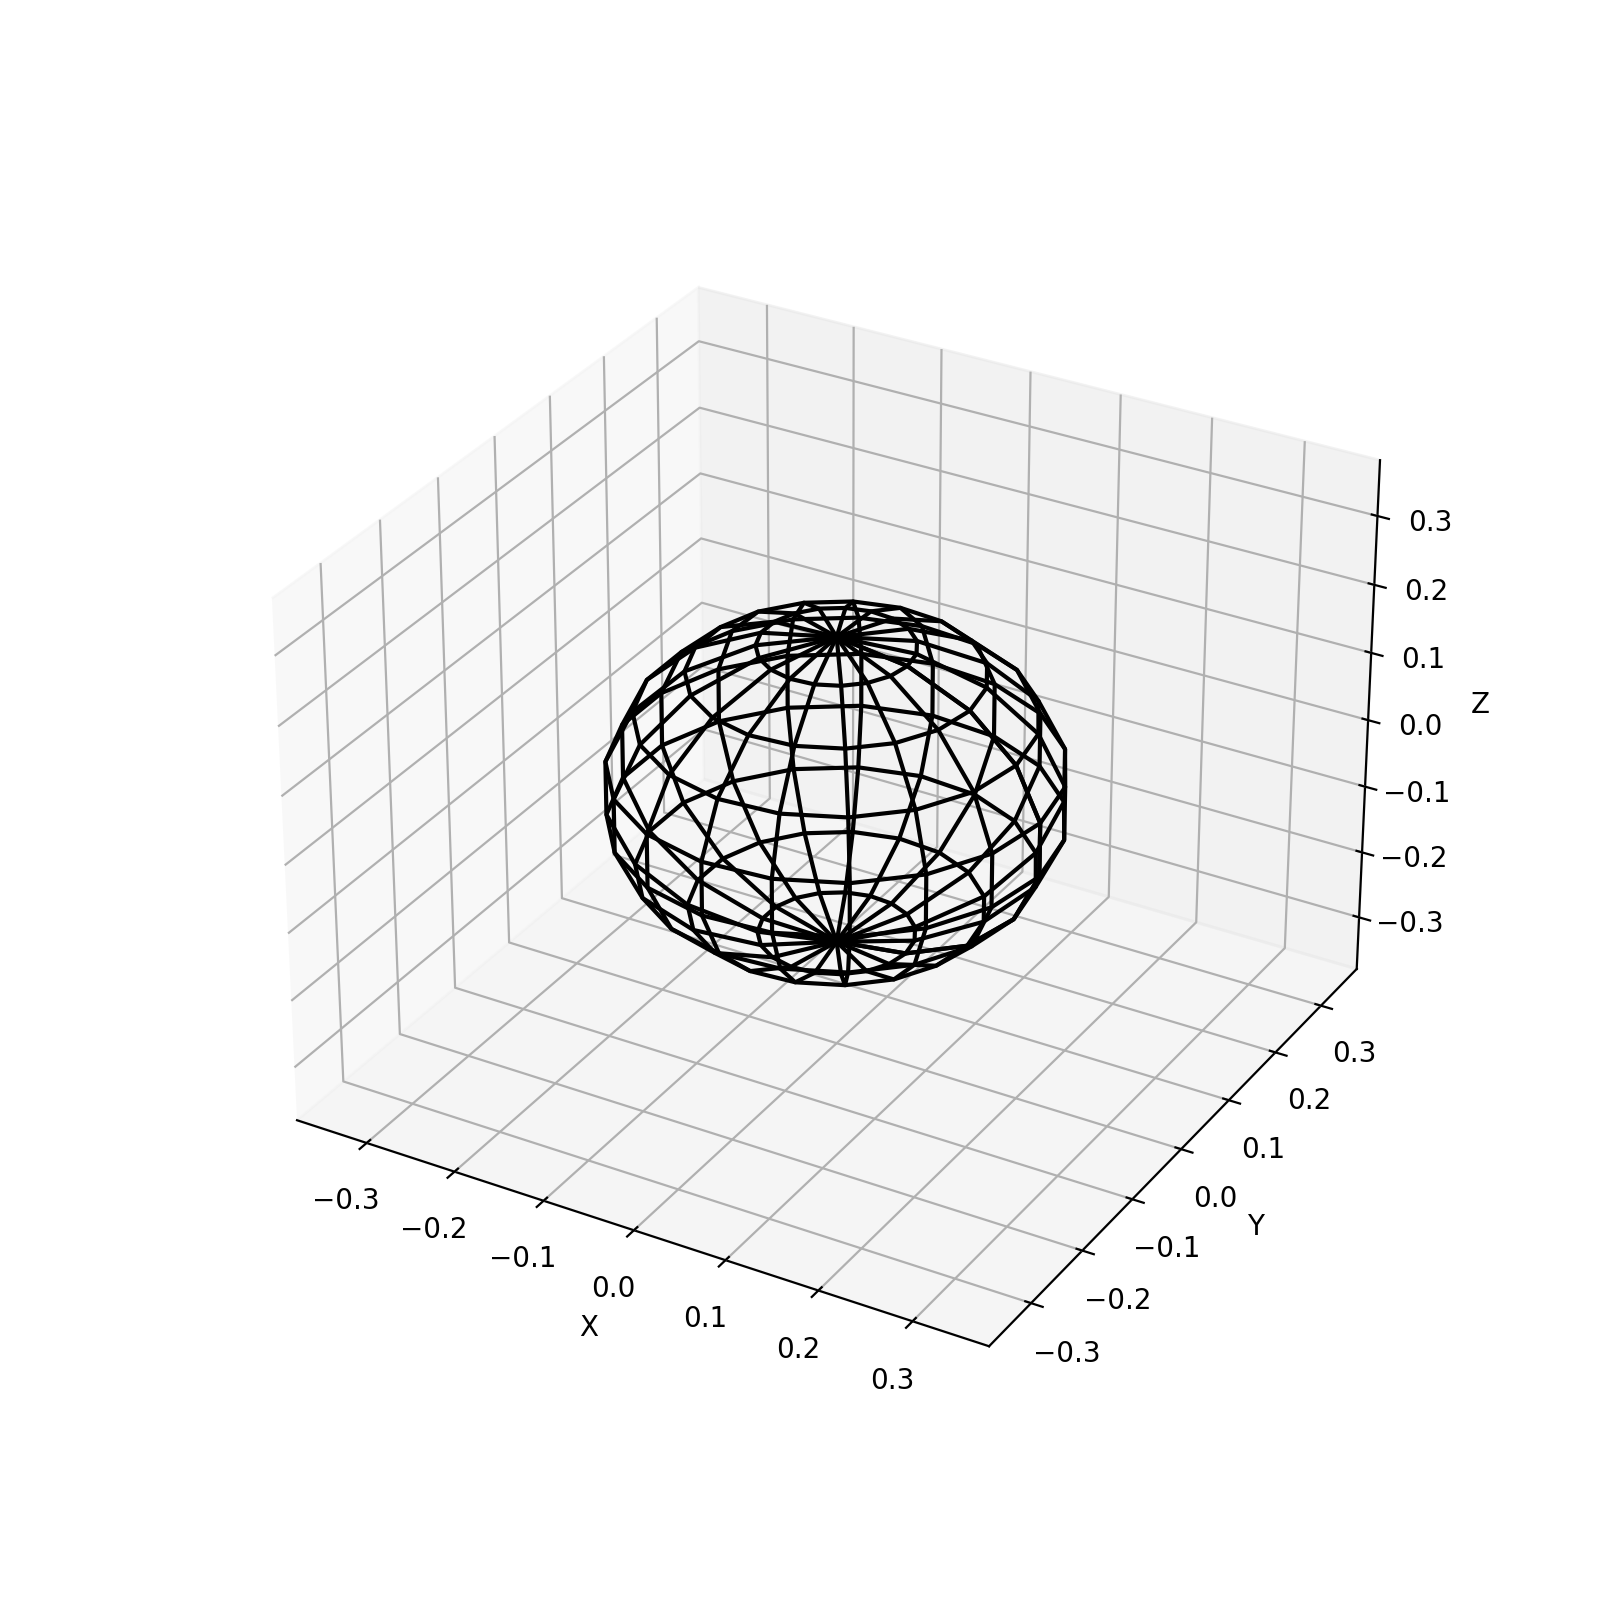

In [33]:
if run_visualization:
    %matplotlib notebook
    fig = plt.subplots(figsize=(8,8))
    ax = plt.axes(projection='3d')

    # Plot filaments
    for fil in f_list:
        fil.Plot3(ax)

    # Plot sphere wireframe
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = R*np.cos(u)*np.sin(v)
    y = R*np.sin(u)*np.sin(v)
    z = R*np.cos(v)
    ax.plot_wireframe(x, y, z, color="black")

    ax.set_xlim3d(-R-Lmax/2, R+Lmax/2)
    ax.set_ylim3d(-R-Lmax/2, R+Lmax/2)
    ax.set_zlim3d(-R-Lmax/2, R+Lmax/2)
    ax.set(xlabel='X', ylabel='Y', zlabel='Z')

In [32]:
if write_file:
    
    # first offset system
    for fil in f_list:
        fil.pos_start += np.array(system_offset)
        fil.pos_end += np.array(system_offset)
        fil.center += np.array(system_offset)
    filer = open(fname,"w")
    filer.write('# Initial configuration of rods\n#\n')
    for fil in f_list:
        filer.write( fil.GetStringtoWrite() )
    filer.close()

## Tests:

### Minimum distance function:

In [13]:
if run_tests:
    # parallel lines with separation 1 in X
    gid=0
    f1 = Filament([0,0,0], [0,0,1],2)
    f2 = Filament([1,0,0], [0,0,1],2)
    print('Expected Distance =   1.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))

    # parallel lines with separation 1 in X and Y
    gid=0
    f1 = Filament([0,0,0], [0,0,1],2)
    f2 = Filament([1,0,1], [0,0,1],2)
    print('Expected Distance =   1.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))

    # parallel overlapping lines with only endpoints touching
    gid=0
    f1 = Filament([0,0,0], [0,0,1],2)
    f2 = Filament([0,0,2], [0,0,1],2)
    print('Expected Distance =   0.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))

    # parallel overlapping lines with one line inside another
    gid=0
    f1 = Filament([0,0,0], [0,0,1],1)
    f2 = Filament([0,0,0], [0,0,1],2)
    print('Expected Distance =   0.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))

    # parallel lines with same XY and separated in Z by 1
    gid=0
    f1 = Filament([0,0,0], [0,0,1],2)
    f2 = Filament([0,0,3], [0,0,1],2)
    print('Expected Distance =   1.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))


### Uniform Centers Distribution:

In [22]:
if run_tests:
    xs = []
    ys = []
    zs = []
    rs = []
    thetas = []
    phis=[]
    for k in range(5000):
        center = getRand3PointInSphere(R)
        xs.append( center[0])
        ys.append( center[1])
        zs.append( center[2])
        rpt = cart2sph( center[0], center[1], center[2])
        rs.append( rpt[0])
        thetas.append(rpt[2])
        phis.append(rpt[1])

    %matplotlib inline
    fig,axs = plt.subplots(2,3, figsize=(15, 10), sharey=True,tight_layout=True)
    axs[0,0].hist( xs, bins=10)
    axs[0,0].set(xlabel='X',ylabel='Counts')
    axs[0,1].hist( ys, bins=10)
    axs[0,1].set(xlabel='Y')
    axs[0,2].hist( zs, bins=10)
    axs[0,2].set(xlabel='Z')
    axs[1,0].hist( rs, bins=10)
    axs[1,0].set(xlabel='r',ylabel='Counts')
    axs[1,1].hist( phis, bins=10)
    axs[1,1].set(xlabel='phi')
    axs[1,2].hist( thetas, bins=10)
    axs[1,2].set(xlabel='theta')

    plt.suptitle('test')
    plt.show()
    %matplotlib notebook

    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.scatter(xs,ys,zs, marker='.',s=4)

### Length Exponential Distribution:

In [31]:
if run_tests:
    nFil = 100000
    lens = []
    for i in range(nFil):
        lens.append( getLengthRandomExp(rng, Lmean, Lmin, Lmax))

    fig = plt.subplots(figsize=(8,6))
    ax = plt.axes()
    ax.hist( lens, bins=15)

    ax.set(xlabel='Length (micron)', ylabel='Count', title='Exponential distribution (mean = {} micron)'.format(Lmean))